<a href="https://colab.research.google.com/github/priorejana/modelo-comentarios/blob/main/classificador-comentarios-video-on%C3%A7a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Preparação dos Dados

In [1]:
!pip install transformers torch

In [2]:
import pandas as pd

In [3]:
url_planilha = "https://docs.google.com/spreadsheets/d/17aHYyRNfbmde8bVOR_HX_BmNUEdkygPuaGO4lJj26jg/export?format=csv"

In [4]:
df_completo = pd.read_csv(url_planilha)
df_completo.head()

,video,onca,caseiro,fake news,ironia,notícia,Conservacionistas,comment_text
0,video0,neutro,neutro,não,sim,neutra,NaN,Solta no congresso
1,video0,neutro,neutro,não,não,boa,NaN,"vídeo direto, respeitoso, sem sensacionalismo ..."
2,video0,neutro,neutro,não,não,boa,NaN,Essa reportagem foi a melhor parabéns
3,video0,neutro,negativo,não,não,neutra,NaN,As patas 🐾 das onças no chão foi um aviso pra ...
4,video0,neutro,negativo,não,não,neutra,NaN,Se o cara viu que onça estava rondando a casa ...


In [5]:
coluna = 'onca'
comentario_texto = 'comment_text'

In [6]:
rotulos = ['positivo', 'negativo', 'neutro']

In [7]:
df_filtrado = df_completo[df_completo[coluna].isin(rotulos)].copy()
df_limpo = df_filtrado.dropna(subset=[comentario_texto])
df_limpo = df_limpo.drop_duplicates(subset=[comentario_texto])

In [8]:
mapa_de_rotulos = {
    'negativo': 0,
    'neutro': 1,
    'positivo': 2
}

In [9]:
df_limpo['label_num'] = df_limpo[coluna].map(mapa_de_rotulos)

In [10]:
print(f"Total de amostras: {len(df_limpo)}")
print("\nContagem de classes:")
print(df_limpo['onca'].value_counts())
df_limpo.head()

Total de amostras: 4495

Contagem de classes:
onca
neutro      3417
negativo     717
positivo     361
Name: count, dtype: int64


,video,onca,caseiro,fake news,ironia,notícia,Conservacionistas,comment_text,label_num
0,video0,neutro,neutro,não,sim,neutra,NaN,Solta no congresso,1
1,video0,neutro,neutro,não,não,boa,NaN,"vídeo direto, respeitoso, sem sensacionalismo ...",1
2,video0,neutro,neutro,não,não,boa,NaN,Essa reportagem foi a melhor parabéns,1
3,video0,neutro,negativo,não,não,neutra,NaN,As patas 🐾 das onças no chão foi um aviso pra ...,1
4,video0,neutro,negativo,não,não,neutra,NaN,Se o cara viu que onça estava rondando a casa ...,1


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X = df_limpo[comentario_texto]
y = df_limpo['label_num']

# 70% Treino e 30% (Val + Teste)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

# Divide os 30% em 15% Validação e 15% Teste
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

In [13]:
print(f"Amostras de Treino: {len(X_train)}")
print(f"Amostras de Validação: {len(X_val)}")
print(f"Amostras de Teste: {len(X_test)}")

Amostras de Treino: 3146
Amostras de Validação: 674
Amostras de Teste: 675


# 2. Tokenização

In [14]:
import torch
from transformers import AutoTokenizer

In [15]:
nome_modelo = 'neuralmind/bert-base-portuguese-cased'
tokenizer = AutoTokenizer.from_pretrained(nome_modelo)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [16]:
MAX_LEN = 128

In [17]:
textos_treino = X_train.tolist()
textos_val = X_val.tolist()
textos_teste = X_test.tolist()

In [18]:
# Tokeniza o conjunto de Treino
encodings_treino = tokenizer(
    textos_treino,
    truncation=True,
    padding='max_length',
    max_length=MAX_LEN,
    return_tensors='pt'
)

In [19]:
# Tokeniza o conjunto de Validação
encodings_val = tokenizer(
    textos_val,
    truncation=True,
    padding='max_length',
    max_length=MAX_LEN,
    return_tensors='pt'
)

In [20]:
# Tokeniza o conjunto de Teste
encodings_teste = tokenizer(
    textos_teste,
    truncation=True,
    padding='max_length',
    max_length=MAX_LEN,
    return_tensors='pt'
)

In [21]:
print("Exemplo de chaves geradas:", encodings_treino.keys())

Exemplo de chaves geradas: KeysView({'input_ids': tensor([[  101, 11521,   265,  ...,     0,     0,     0],
        [  101,   461, 22331,  ...,     0,     0,     0],
        [  101,   461, 22331,  ...,     0,     0,     0],
        ...,
        [  101, 17911,  5283,  ...,     0,     0,     0],
        [  101,   192,   189,  ...,     0,     0,     0],
        [  101,   177,  3185,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])})


In [22]:
print("Shape dos input_ids de treino:", encodings_treino['input_ids'].shape)

Shape dos input_ids de treino: torch.Size([3146, 128])


In [23]:
y_train_tensor = torch.tensor(y_train.values)
y_val_tensor = torch.tensor(y_val.values)
y_test_tensor = torch.tensor(y_test.values)

In [24]:
print("Shape dos rótulos de treino:", y_train_tensor.shape)
print("Shape dos rótulos de validação:", y_val_tensor.shape)

Shape dos rótulos de treino: torch.Size([3146])
Shape dos rótulos de validação: torch.Size([674])


# 3. Modelo

In [25]:
from torch import nn
from transformers import BertModel

In [26]:
class ClassificadorBERT(nn.Module):
    def __init__(self, num_classes):

        super(ClassificadorBERT, self).__init__()

        self.bert = BertModel.from_pretrained(nome_modelo)


        self.classificador = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        pooler_output = outputs[1]

        logits = self.classificador(pooler_output)

        return logits

In [27]:
NUM_CLASSES = 3
modelo = ClassificadorBERT(num_classes=NUM_CLASSES)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo = modelo.to(device)
print(f"Modelo movido para o dispositivo: {device}")
try:
    ids_teste = encodings_treino['input_ids'][0:2].to(device)
    mask_teste = encodings_treino['attention_mask'][0:2].to(device)

    with torch.no_grad():
        saidas = modelo(ids_teste, mask_teste)

    print("\n--- Teste ---")
    print("Shape (formato) da saída do modelo:", saidas.shape)
    print("(Esperado: [2, 3] -> 2 amostras, 3 scores de classe)")

except Exception as e:
    print(f"\nO teste de fumaça falhou: {e}")
    print("Verifique se as Etapas 1 e 2 rodaram corretamente.")

Modelo movido para o dispositivo: cuda

--- Teste ---
Shape (formato) da saída do modelo: torch.Size([2, 3])
(Esperado: [2, 3] -> 2 amostras, 3 scores de classe)


# 4. Treinamento

In [28]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [29]:
# Combina os tensores de treino em um único Dataset
dataset_treino = TensorDataset(
    encodings_treino['input_ids'],
    encodings_treino['attention_mask'],
    y_train_tensor
)

In [30]:
# Combina os tensores de validação em um único Dataset
dataset_val = TensorDataset(
    encodings_val['input_ids'],
    encodings_val['attention_mask'],
    y_val_tensor
)

In [31]:
TAMANHO_BATCH = 16

In [32]:
# Cria o DataLoader de Treino.
dataloader_treino = DataLoader(
    dataset_treino,
    sampler=RandomSampler(dataset_treino),
    batch_size=TAMANHO_BATCH
)

In [33]:
# Cria o DataLoader de Validação.
dataloader_val = DataLoader(
    dataset_val,
    sampler=SequentialSampler(dataset_val),
    batch_size=TAMANHO_BATCH
)

In [34]:
# Quantidade de batches de treino
print(len(dataloader_treino))

197


In [35]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
import numpy as np

In [36]:
otimizador = AdamW(
    modelo.parameters(),
    lr=2e-5
)

In [37]:
funcao_de_perda = CrossEntropyLoss()

In [38]:
def calcular_acuracia(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(preds_flat == labels_flat) / len(labels_flat)

In [39]:
import time

In [40]:
NUM_EPOCHS = 10

In [41]:
historico_loss_treino = []
historico_loss_val = []
best_val_accuracy = 0.0
melhor_modelo = 'modelo_campeao.pth'

In [42]:
for epoch in range(NUM_EPOCHS):

    print(f"\nÉpoca {epoch + 1} / {NUM_EPOCHS}")

    # Treinamento
    modelo.train()
    total_loss_treino = 0

    for batch in dataloader_treino:

        modelo.zero_grad()

        batch_input_ids = batch[0].to(device)
        batch_attention_mask = batch[1].to(device)
        batch_labels = batch[2].to(device)

        # 1. Faz a previsão
        logits = modelo(batch_input_ids, batch_attention_mask)

        # 2. Calcula o erro (loss)
        loss = funcao_de_perda(logits, batch_labels)
        total_loss_treino += loss.item()

        # 3. Calcula os gradientes
        loss.backward()

        # 4. Atualiza os pesos
        otimizador.step()

    # Média de loss de treino da época
    avg_loss_treino = total_loss_treino / len(dataloader_treino)
    historico_loss_treino.append(avg_loss_treino)

    # Validação
    modelo.eval()

    total_loss_val = 0
    total_acuracia_val = 0

    with torch.no_grad():
        for batch in dataloader_val:

            batch_input_ids = batch[0].to(device)
            batch_attention_mask = batch[1].to(device)
            batch_labels = batch[2].to(device)

            # 1. Faz a previsão
            logits = modelo(batch_input_ids, batch_attention_mask)

            # 2. Calcula o erro (loss)
            loss = funcao_de_perda(logits, batch_labels)
            total_loss_val += loss.item()

            # 3. Calcula a acurácia
            logits_cpu = logits.detach().cpu().numpy()
            labels_cpu = batch_labels.to('cpu').numpy()
            total_acuracia_val += calcular_acuracia(logits_cpu, labels_cpu)

    # Médias de loss e acurácia da validação
    avg_loss_val = total_loss_val / len(dataloader_val)
    avg_acuracia_val = total_acuracia_val / len(dataloader_val)
    historico_loss_val.append(avg_loss_val)

    # Print do relatório da época
    print(f"  Loss de Treino: {avg_loss_treino:.4f}")
    print(f"  Loss de Validação: {avg_loss_val:.4f}")
    print(f"  Acurácia de Validação: {avg_acuracia_val:.4f}")

    if avg_acuracia_val > best_val_accuracy:
        best_val_accuracy = avg_acuracia_val
        # Salva o "state_dict" (os pesos) do modelo campeão
        torch.save(modelo.state_dict(), melhor_modelo)
        print(f"Nova melhor acurácia! Modelo salvo em '{melhor_modelo}'")


Época 1 / 10
  Loss de Treino: 0.6025
  Loss de Validação: 0.4994
  Acurácia de Validação: 0.7878
Nova melhor acurácia! Modelo salvo em 'modelo_campeao.pth'

Época 2 / 10
  Loss de Treino: 0.4554
  Loss de Validação: 0.4686
  Acurácia de Validação: 0.8009
Nova melhor acurácia! Modelo salvo em 'modelo_campeao.pth'

Época 3 / 10
  Loss de Treino: 0.3059
  Loss de Validação: 0.4363
  Acurácia de Validação: 0.8343
Nova melhor acurácia! Modelo salvo em 'modelo_campeao.pth'

Época 4 / 10
  Loss de Treino: 0.1702
  Loss de Validação: 0.5534
  Acurácia de Validação: 0.8023

Época 5 / 10
  Loss de Treino: 0.0984
  Loss de Validação: 0.6614
  Acurácia de Validação: 0.7994

Época 6 / 10
  Loss de Treino: 0.0562
  Loss de Validação: 0.7150
  Acurácia de Validação: 0.8125

Época 7 / 10
  Loss de Treino: 0.0334
  Loss de Validação: 0.8531
  Acurácia de Validação: 0.7951

Época 8 / 10
  Loss de Treino: 0.3217
  Loss de Validação: 0.7333
  Acurácia de Validação: 0.8067

Época 9 / 10
  Loss de Treino:

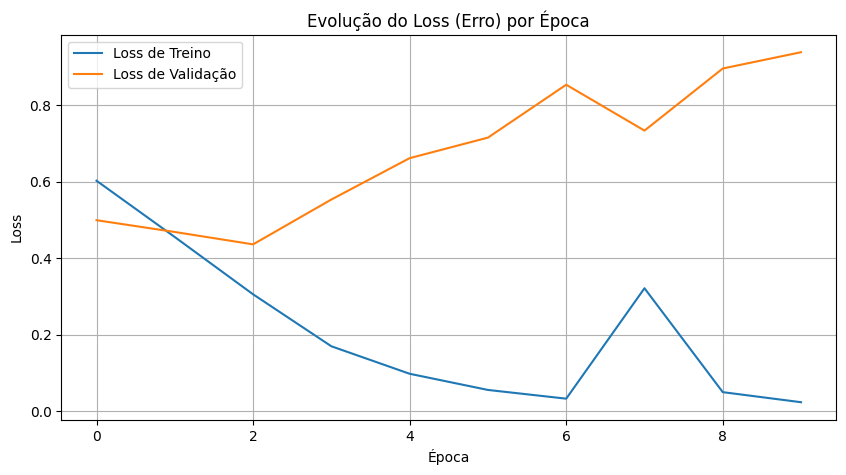

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(historico_loss_treino, label='Loss de Treino')
plt.plot(historico_loss_val, label='Loss de Validação')
plt.title('Evolução do Loss (Erro) por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 5. Avaliação

In [44]:
# Recria a arquitetura vazia do modelo
modelo_campeao = ClassificadorBERT(num_classes=NUM_CLASSES)

# Carrega os pesos (o 'state_dict') do melhor modelo
modelo_campeao.load_state_dict(torch.load('modelo_campeao.pth'))
modelo_campeao = modelo_campeao.to(device)
modelo_campeao.eval()

ClassificadorBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [45]:
# Prepara o DataLoader de teste
dataset_teste = TensorDataset(
    encodings_teste['input_ids'],
    encodings_teste['attention_mask'],
    y_test_tensor
)

dataloader_teste = DataLoader(
    dataset_teste,
    sampler=SequentialSampler(dataset_teste),
    batch_size=TAMANHO_BATCH
)

In [46]:
# Loop de Avaliação no Teste
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in dataloader_teste:
        batch_input_ids = batch[0].to(device)
        batch_attention_mask = batch[1].to(device)
        batch_labels = batch[2].to(device)

        logits = modelo_campeao(batch_input_ids, batch_attention_mask)

        # Converte logits para previsões (0, 1 ou 2)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = batch_labels.cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

In [47]:
from sklearn.metrics import classification_report, accuracy_score

In [48]:
acuracia_final = accuracy_score(all_labels, all_preds)
print(f"Acurácia Final no Teste: {acuracia_final * 100:.2f}%")

print("\nRelatório de Classificação (Precision, Recall, F1-Score):")
nomes_das_classes = ['negativo', 'neutro', 'positivo']
print(classification_report(all_labels, all_preds, target_names=nomes_das_classes))

Acurácia Final no Teste: 81.04%

Relatório de Classificação (Precision, Recall, F1-Score):
              precision    recall  f1-score   support

    negativo       0.53      0.66      0.59       108
      neutro       0.90      0.88      0.89       513
    positivo       0.60      0.48      0.54        54

    accuracy                           0.81       675
   macro avg       0.68      0.67      0.67       675
weighted avg       0.82      0.81      0.81       675



## Testes

In [49]:
df_teste = pd.DataFrame({
    'texto': X_test,
    'rotulo_verdadeiro': y_test.values,
    'previsao_modelo': all_preds
})

In [50]:
mapa_inverso = {
    0: 'negativo',
    1: 'neutro',
    2: 'positivo'
}
df_teste['rotulo_verdadeiro'] = df_teste['rotulo_verdadeiro'].map(mapa_inverso)
df_teste['previsao_modelo'] = df_teste['previsao_modelo'].map(mapa_inverso)

In [51]:
erros = df_teste[df_teste['rotulo_verdadeiro'] != df_teste['previsao_modelo']]

In [52]:
pd.set_option('display.max_colwidth', 300)
print(f"O modelo errou em {len(erros)} de {len(df_teste)} amostras de teste.")
print("\nExemplos de erros:")
print(erros.head())

O modelo errou em 128 de 675 amostras de teste.

Exemplos de erros:
                                                                                                                                                                                                                                                texto  \
2027                                                                                                                                                           Não faltou experiência, faltou vigilância, e ele vacilou  teria é que rapar fogo nela.   
1915  A verdade é que a ganância do homem, cada vez mais avança em áreas de mata, para colocarem gado, plantarem soja , construírem pousadas e etc.   Precisamos repensar se não incentivamos tudo isso, com turismo excessivo, consumo despedidos ??   
144                                                                              O problema tbem, é q se outra onças, provaram da carne huma , e beberam o sangue do Sr George!! Provavel

## Demonstração

In [104]:
artigo_para_teste = "que reportagem boa"

In [106]:
encoding_novo = tokenizer(
    [artigo_para_teste],
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='pt'
)
ids_novo = encoding_novo['input_ids'].to(device)
mask_novo = encoding_novo['attention_mask'].to(device)
with torch.no_grad():
    logits = modelo_campeao(ids_novo, mask_novo)
previsao_numerica = torch.argmax(logits, dim=1).cpu().numpy()[0]
mapa_inverso = {0: 'negativo', 1: 'neutro', 2: 'positivo'}
previsao_texto = mapa_inverso[previsao_numerica]
print(f"  Previsão do Modelo: {previsao_texto.upper()}")

  Previsão do Modelo: NEUTRO
